# Notebook for Stanford GSB Technical Assessment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
        
def mycdf( x , y , plotter , color=None , label=None , sort=False ) : 
    
    """ Custom CDF-style plotter for this assessment """
    
    if x.size != y.size : 
        raise ValueError("expect x and y to be the same size")
    # make "corners" in between points
    X , Y = np.zeros( 2*x.size-1 ) , np.zeros( 2*y.size-1 )
    if sort : 
        i = np.argsort( y )
        X[0::2] , Y[0::2] = x[i].copy() , y[i].copy()
    else : X[0::2] , Y[0::2] = x.copy() , y.copy()
    for n in range(0,x.size-1) : # can be done with an operation
        X[2*n+1] , Y[2*n+1] = X[2*(n+1)] , Y[2*n]
    if color is None : plotter( X , Y , linestyle='-' , label=label )
    else : plotter( X , Y , color=color , linestyle='-' , label=label )

# import master file, as this is useful everywhere below (so far)
masterfile = "baseballdatabank-master/core/master.csv"
df_m = pd.read_csv( masterfile )
df_m.set_index( 'playerID' , drop=True , inplace=True )

# Q1

_Evaluate the Hall of Fame status of players as a result of country of origin for a faculty member's research project. Make a plot of players in the hall of fame over time, grouped by each country._

First we will read in two parts of the data set: the master file (above) and the Hall of Fame file. The master file has birth country and the hall of fame file has nomination year, induction (or not), and player or other role. We'll hack together a join over the playerID's by selecting over the right dataframe indices. Then we'll get counts by country using a groupby-count operation, and take cumulative sums. Then we can export the data (save as a csv file) as well as plot here. 

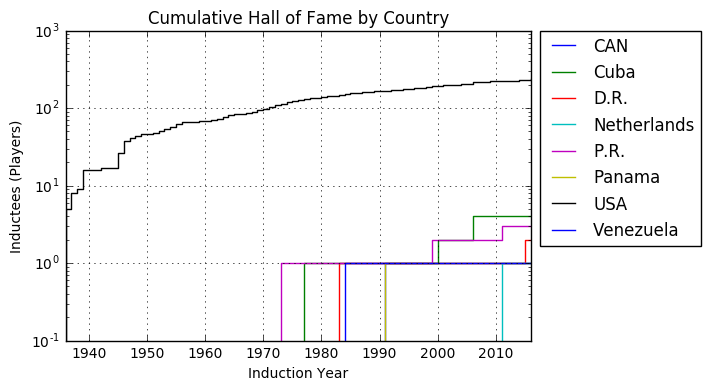

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for analysis and plotting related to the Hall of Fame. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

hoffile = "baseballdatabank-master/core/HallOfFame.csv"

df_h = pd.read_csv( hoffile )
df_h = df_h[ df_h['category'] == 'Player' ] # focus here on player inductees
# df_h = df_h[ df_h['category'] != 'Player' ] # focus here on non-player inductees
df_h = df_h[ df_h['inducted'] == 'Y' ] # focus on actual inductions, not just nominations
df = df_h[['playerID','yearid']].copy()

df['birthCountry'] = df_m['birthCountry'].loc[ df['playerID'] ].values

bc = list( df_m['birthCountry'].unique() ) # iterable

df.sort_values( 'yearid' , axis=0 , inplace=True )
gdf = df.groupby(['yearid','birthCountry'])
adf = gdf['playerID'].agg( { 'count' : 'count' } )
adf.reset_index( inplace=True )
adf.sort_values( ['birthCountry','yearid'] , axis=0 , inplace=True )
adf.set_index( ['birthCountry','yearid'] , drop=True , inplace=True )

bdf = pd.DataFrame( np.zeros((2017-1935,adf.index.levels[0].size)) , \
                    index=np.arange(1935,2017) , \
                    columns=adf.index.levels[0] )

for c in adf.index.levels[0] :
    try : 
        tmp = adf['count'].loc[c]
        bdf[c].loc[ tmp.index ] = tmp.values.copy()
        tmp[:] = np.cumsum( tmp.values )
        tmp.loc[2016] = np.max( tmp.values )
        tmp.loc[1935] = 1.0e-16
        tmp.sort_index( inplace=True )
        mycdf( tmp.index , tmp.values , plt.semilogy , label=c )
    except KeyError as e : 
        pass # print( 'Country %s not in HOF data' % c )
    except TypeError as e : 
        print( 'error (%s): %s' % (c,e) )

bdf = bdf.cumsum()
bdf.to_csv( "HallOfFameByBirthCountry.csv" )

plt.ylim( [0.1,1e3] )
plt.xlim( [1936,2016] )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
plt.grid( True , linestyle=':' )
plt.title( 'Cumulative Hall of Fame by Country' )
plt.xlabel( 'Induction Year' )
plt.ylabel( 'Inductees (Players)' )

In [91]:
# formatting for MetricsGraphics (easy way, following the examples)

# for i in adf.index.levels[0] : print( adf.loc[i,:] )

f = open( "testout.json" , "w" )
f.write( '[\n' )
for i in adf.index.levels[0] : 
    f.write('[')
    tmp = adf.loc[i,:]
    j , d , y = 0 , 0 , tmp.index[0]
    while j < tmp.shape[0] :
        if j > 0 : f.write( "," )
        while y < tmp.index[j] : 
            f.write(  "{" + "\"date\":\"" + ( "%i" % y ) + "-01-01\",\"value\":" + ( "%i" % d ) + "}," )
            y += 1
        f.write(  "{" + "\"date\":\"" + ( "%i" % y ) + "-01-01\",\"value\":" + ( "%i" % d ) + "}" )
        d = tmp.iloc[j]
        f.write( ",{" + "\"date\":\"" + ( "%i" % y ) + "-01-01\",\"value\":" + ( "%i" % d ) + "}" )
        j += 1
    while y < 2016 : 
        f.write( ",{" + "\"date\":\"" + ( "%i" % y ) + "-01-01\",\"value\":" + ( "%i" % d ) + "}" )
        y += 1
    f.write('],\n') # need a hack to get the last comma excluded
f.write(']')
f.close()


In [ ]:
# TBD: write a csv version for MetricsGraphics, D3.js testing



In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# End Q1
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Q2

_What questions would you ask as follow ups?_

Basic questions about deliverables: 

1. Is this the sort of thing you're looking for? 
2. Did we understand the data well enough? Miss any important subtleties about the field, baseball (I very well might)? 
3. Is the plot ok? Need a different image format, or different style (e.g., D3 graphic? 
4. Is the data itself useful? That is, the aggregated data in csv format. 

Basically, does this work adequately support you, and what else needs to be done (being careful about what is revision versus what is a new project). 

But I am mainly interested in asking: "What is the purpose of the analysis?" That isn't particularly specific, so I thought of the following: 

1. Are you interested in _likelihood_ of Hall of Fame nomination and/or induction for players by country? 
2. Hall of Fame nomination/induction for non-player roles by country? 
3. Hall of Fame nominee/inductee by performance, and whether that depends on country? 

I guess all these questions are leaning towards: _Are there country-specific disparities leading to nomination/induction?_

Also, what actual statistics are relevant? That is, I can envision modeling things like the probability of nomination given "performance" and country, and looking for "significant" effects on country, although the large bias towards US players in the data makes that touchy. Grouping (e.g., US, not US) might be an option there. Or, modeling probability of induction given nomination as a function of country. 

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# likelihood? How would we assess this? 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

gdf = df_m.groupby( ['birthCountry'] )


In [123]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# repeated nominations? 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

hoffile = "baseballdatabank-master/core/HallOfFame.csv"

df_h = pd.read_csv( hoffile )
df_h = df_h[ df_h['category'] == 'Player' ] # focus here on player inductees
# df_h = df_h[ df_h['category'] != 'Player' ] # focus here on non-player inductees
df_h['birthCountry'] = df_m['birthCountry'].loc[ df_h['playerID'] ].values

print( 'Number of unique player nominations: %i' % df_h['playerID'].unique().shape[0] )
print( 'Number of total nominations: %i' % df_h.shape[0] )

# converting to a dummy variable allows for the aggregation operation below
df_h['inducted_dummy'] = df_h['inducted'].apply( lambda x : 1 if x == 'Y' else 0 )
df_h['inducted'] = df_h['inducted_dummy'] * df_h['yearid']

gdf = df_h.groupby( 'playerID' )
adf = gdf['inducted'].agg( { 'nominations' : 'count' , 'inducted' : max } )
adf['birthCountry'] = df_m['birthCountry'].loc[ adf.index ].values
bdf = gdf['yearid'].agg( { 'firstNom' : min , 'lastNom' : max } )
adf['firstNom'] = bdf['firstNom']
adf['lastNom'] = bdf['lastNom']


Number of unique player nominations: 1189
Number of total nominations: 3997


In [124]:
# If we need debut year and years active, this set of commands gives us that

# print( df_m.groupby( 'birthCountry' ).count() )
# df_m['debut_year'] = df_m['debut']
df_m['debut'] = pd.to_datetime( df_m['debut'] )
df_m['finalGame'] = pd.to_datetime( df_m['finalGame'] )

try: del df
except : pass

df = df_m[['birthCountry','debut','finalGame']].copy()
df['debut_year']  = df['debut'].dt.year
# df['debut_month'] = df['debut'].dt.month
# df['debut_day']   = df['debut'].dt.day
df['final_year']  = df['finalGame'].dt.year
# df['final_month'] = df['finalGame'].dt.month
# df['final_day']   = df['finalGame'].dt.day
df = df.drop(['debut','finalGame'],axis=1)
df['activeYears'] = df['final_year'] - df['debut_year'] + 1

gdf = df.groupby( ['birthCountry','debut_year'] )

# print( df )


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# End Q2
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Q3

_The same faculty member is investigating popularity of players based on a number of different approaches, but is especially interested in visits and/or edits of player Wikipedia pages.  Produce a plot of the most popular players by time in a way that feels descriptive and compelling to you._

I'm more interested in views than edits, but either is possible. My process is to use multiple platforms and steps:

1. I'll use python (here) to create a list of player names stored in a single file as they would be formatted for Wikipedia pages. For example, "Mark McGuire" as "Mark_McGuire". I also use python to test URLs at Wikipedia using this simple formatting, via the requests module and "head" method (just get header and check status code). 
2. I'll then use the Pageviews API (https://wikitech.wikimedia.org/wiki/Analytics/PageviewAPI) via a bash shell using the `curl` utility. This will enable (bash) scripting queries to Wikipedia about pageviews, but appears to only have data from July 2015 onward (for these pages). 
3. To better parse and package the data, I've written a program in C, "wikipiper", that can be used in the shell via "`curl <url> | ./wikipiper(.exe) <options>`". This program extracts view data from a query result, storing it along with a time stamp. 
4. This data can then be read in in python, specifically here in jupyter, as a datafile along with other files. 

Caveats:

1. We should be careful about using this data "naively." I've ran for views from all agents, for example,  but we may want to restrict to views from users only. We may also want to cross-reference against the revision history, to separate views related to revision from views related to general interest. 
2. Other data is available in archives at https://dumps.wikimedia.org/other/pagecounts-raw/, however that would take more work to trawl through for these specific results. 

__WARNING__: Some of this analysis takes a bit of time to run, so be careful. 

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for Wikipedia URL checking. 
# 
# HTTP status codes reviewed at: http://www.restapitutorial.com/httpstatuscodes.html
# 
# WARNING: DO NOT REPEATEDLY RUN; this takes time. Load dataframe from WikiURLs.csv instead. 
# 
# NOTE: where is the copy of a slice? 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import requests

URLs = pd.DataFrame( np.zeros( (df_m.shape[0],2) ) , columns=['url','status'] , index=df_m.index )
URLs['url'] = ( 'https://en.wikipedia.org/wiki/' + df_m['nameFirst'] + '_' + df_m['nameLast'] ).copy()
URLs['url'] = URLs['url'].str.replace( ' ' , '_' ) # replace (other) white space with an underscore
URLs['url'] = URLs['url'].str.replace( '\'' , '%27' ) # replace apostrophes with HTTP code

URLs['status'] = 404 * np.ones( URLs.shape[0] ) # initialize to no valid site

for u in range(0,URLs.shape[0]) : 
    try : 
        r = requests.head(URLs['url'].iloc[u])
        URLs['status'].iloc[u] = r.status_code
    except Exception as e : 
        print( 'Exception encountered: url: %s (%s)' % (URLs['url'].iloc[u],e) )

URLs.to_csv( "WikiURLs.csv" )


C:\Users\William\Anaconda3\envs\python3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [69]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for interactive revision and checking 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

print( URLs.shape[0] , np.sum( URLs['status'].values == 200 ) , URLs.shape[0] - np.sum( URLs['status'].values == 200 ) )
print( URLs.shape[0] , np.sum( URLs['status'].values == 404 ) )
print( URLs['status'].unique() )

# URLs['url'].loc[ URLs['status'] == 404 ] = URLs['url'].loc[ URLs['status'] == 404 ].str.replace( '\'' , '%27' )
# print( URLs.loc[ URLs['status'] == 404 ] )

#for i in URLs.index[ URLs['status'] == 404 ] :
#    try : float( URLs['url'].loc[i] )
#    except Exception : 
#        r = requests.head(URLs['url'].loc[i])
#        print( URLs['url'].loc[i] , r.status_code )
#    else : pass
#    try : 
#        r = requests.head(URLs['url'].loc[i])
#        URLs['status'].loc[i] = r.status_code
#    except Exception as e : 
#        print( 'Exception encountered: url: %s (%s)' % (URLs['url'].iloc[i],e) )

# URLs.to_csv( "WikiURLs.csv" )

# print( df_m[['nameFirst','nameLast','nameGiven']].loc[ URLs['status'] == 404 ] )

18846 18755 91
18846 91
[ 200.  404.]


In [63]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Make bash script to run "curl <url> | ./wikipiper <file>" calls 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

qbody = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/'

f = open( 'wikiqueries.sh' , 'w' )
f.write( "#!/bin/bash\n" )
for u in range(0,URLs.shape[0]) : 
    if URLs['status'].iloc[u] == 200 : 
        
        name = df_m['nameFirst'].iloc[u] + '_' + df_m['nameLast'].iloc[u]
        name = name.replace( ' ' , '_' )
        name = name.replace( '\'' , '%27' )
        # NOTE: need to find a way to escape "bad" characters into HTTP values
        # currently this appears to work, but perhaps could be embedded right
        # in the dataframe. 
        
        query = 'curl ' + qbody \
                        + name \
                        + '/daily/2010010100/2016123100 | ./wikipiper.exe pulled/' + URLs.index[u] \
                        + '\n'
        f.write( query )
        
f.close()

In [87]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Read in files thus created, piling them into a single dataframe. Make sure you size the dataframe first, 
# though, to preallocate... appending would take forever. 
# 
# WARNING: DO NOT REPEATEDLY RUN; this takes time. Load dataframe from wikiviews.pkl instead. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

N = np.sum( URLs['status'] == 200 )

df = pd.read_csv( "pulled/aardsda01.csv" , names=['date','aardsda01'] )
df['date'] = pd.to_datetime( df['date'] )
df.set_index( ['date'] , drop=True , inplace=True )

D = df.shape[0] # hack, presumes full set of dates in this first file
pids = URLs.loc[ URLs['status'] == 200 ].index

DF = pd.DataFrame( np.zeros((D,N),dtype=np.float_) , index=df.index , columns=pids , dtype=np.float_ )

for u in range(0,URLs.shape[0]) : 
    if URLs['status'].iloc[u] == 200 : 
        pid = URLs.index[u]
        df = pd.read_csv( "pulled/" + pid + ".csv" , names=['date',pid] )
        df['date'] = pd.to_datetime( df['date'] )
        df.set_index( ['date'] , drop=True , inplace=True )
        DF[pid] = df.copy()

DF.to_pickle( "wikiviews.pkl" )

(array([ 735780.,  735842.,  735903.,  735964.,  736024.,  736085.,
         736146.,  736208.,  736269.]), <a list of 9 Text xticklabel objects>)

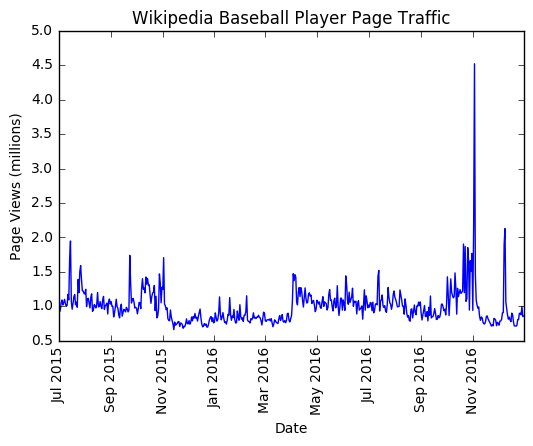

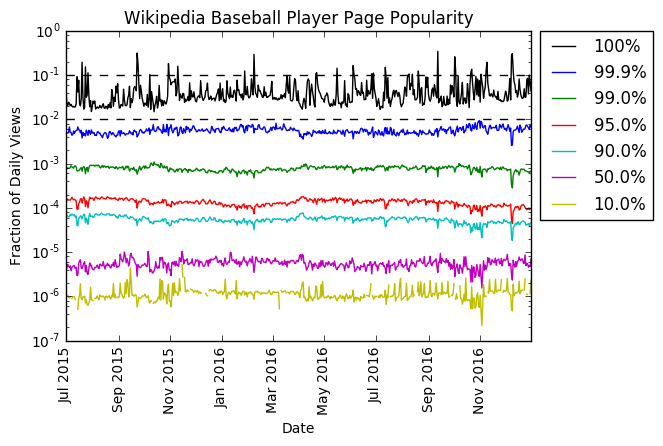

In [46]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Read in the dataframe with page views (since July 1st, 2015) and analyze...
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

DF = pd.read_pickle( "wikiviews.pkl" )
DF.fillna( 0 , inplace=True )

# daily traffic ("views")
V = DF.sum( axis=1 )
plt.figure(1)
plt.plot( V/1e6 )
plt.title( 'Wikipedia Baseball Player Page Traffic' )
plt.xlabel( 'Date' )
plt.ylabel( 'Page Views (millions)' )
plt.xticks( rotation='vertical')

# normalize by daily traffic
DF = DF.div( V , axis=0 )

Q = DF.quantile( np.array([99.9,99,95,90,50,10])/100.0 , axis=1 ).T

plt.figure(2)
plt.semilogy( DF.max( axis=1 ) , color='k' , label='100%' )
for c in Q.columns : 
    plt.semilogy( Q[c] , label=( "%0.1f%%" % (100.0*float(c)) ) )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
plt.semilogy( [DF.index[0],DF.index[-1]] , [0.1,0.1] , '--k' )
plt.semilogy( [DF.index[0],DF.index[-1]] , [0.01,0.01] , '--k' )
plt.title( 'Wikipedia Baseball Player Page Popularity' )
plt.xlabel( 'Date' )
# plt.grid( True )
plt.ylabel( 'Fraction of Daily Views' )
plt.xticks( rotation='vertical')
